First we will import packages


In [191]:


import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import time
from IPython import display
%matplotlib inline


Setup the environment. We will train a model to play the Lunar-Lander-V2 environment from the gym library.

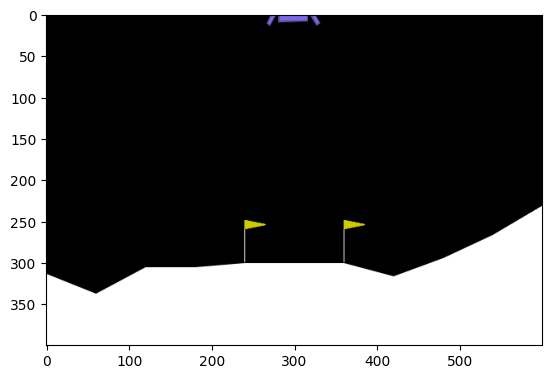

In [192]:
GAME_NAME = 'LunarLander-v2'
env = gym.make(GAME_NAME,render_mode='rgb_array')
state = env.reset()
fig, ax = plt.subplots()

def RenderFrame(env,envState=None):
    ax.clear()  # Clear the previous image
    arr = env.render()
    ax.imshow(arr)
    def DisplayData():
        if envState is None: return
        ax.text(1,1,F"(X, Y): ({envState.x}, {envState.y})")
    DisplayData()
    display.display(fig)  # Display the figure object
    display.clear_output(wait=True)  # Clear the output for the next frame
    






RenderFrame(env)



Let's get an insight into our environment

In [193]:
def PrintEnvironmentSpecs(environmentName: str):
    env = gym.make(environmentName)
    spec = gym.spec(environmentName)
    print(f"Action Space: {env.action_space}")
    print(f"Observation Space: {env.observation_space}")
    print(f"Max Episode Steps: {spec.max_episode_steps}")
    print(f"Nondeterministic: {spec.nondeterministic}")
    print(f"Reward Range: {env.reward_range}")
    print(f"Reward Threshold: {spec.reward_threshold}")

PrintEnvironmentSpecs(GAME_NAME)

Action Space: Discrete(4)
Observation Space: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Max Episode Steps: 1000
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 200


Using this info, lets create a data object to store environment data in a more human-readable format

In [194]:
class EnvironmentState:
    def __init__(self,state):
        coord = state[0]
        self.x = coord[0]
        self.y = coord[1]
        self.x_dot = coord[2]
        self.y_dot = coord[3]
        self.theta = coord[4]
        self.theta_dot = coord[5]
        self.leftLegTouching = int(coord[6])
        self.rightLegTouching = int(coord[7])
        reward = 0
        isDone = False
        if len(state)>2:
            reward = state[1]
            isDone = state[2] or state[3]
        self.reward = reward
        self.isDone = isDone 
    
    def __repr__(self):
        return """
        (x, y): ({self.x}, {self.y})
        (ẋ, ẏ): ({self.x_dot}, {self.y_dot})
        θ: {self.theta}
        dθ/dt: {self.theta_dot}
        Legs touching (L,R): ({self.leftLegTouching}, {self.rightLegTouching})
        Reward: {self.reward}
        Done: {self.isDone}
        """.strip()



Lets take a look at the model's observation

In [195]:
print(state)
print(len(state))
envState = EnvironmentState(state)

print(envState)

(array([-0.00372257,  1.4152824 , -0.37707338,  0.19386216,  0.00432033,
        0.08541282,  0.        ,  0.        ], dtype=float32), {})
2
(x, y): ({self.x}, {self.y})
        (ẋ, ẏ): ({self.x_dot}, {self.y_dot})
        θ: {self.theta}
        dθ/dt: {self.theta_dot}
        Legs touching (L,R): ({self.leftLegTouching}, {self.rightLegTouching})
        Reward: {self.reward}
        Done: {self.isDone}


And lets run a quick iteration of the game, watching the state to make sure everything is working well

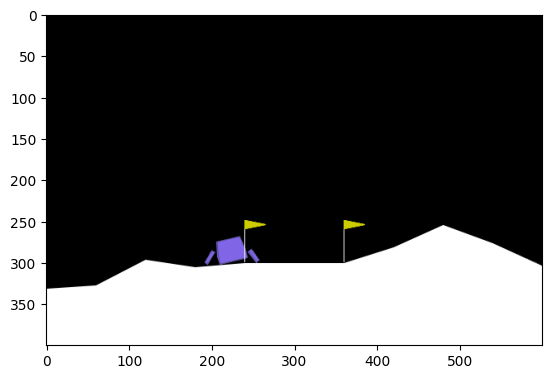

In [196]:
if True:#Change to true/false to play/skip animation
    envState = EnvironmentState(env.reset())
    while not envState.isDone:
        envState = EnvironmentState(env.step(0))
        RenderFrame(env,envState)


Now we'll make a class for the model

In [197]:
class Model:
    pass

    def Decide(state: List[float]) -> List[float]: #returns estimated Q for each action possibility
        pass

def ChooseAction(decision: List[float]) -> List[bool]:
    idx = np.argmax(decision)
    action = np.zeros(len(decision))
    action[idx] = 1
    return action!=0

And some data structures to store the data we will use to train the model

In [198]:
class RawData:
    def __init__(self):
        self.State = None
        self.Action = None
        self.Reward = 0
        self.NextState = None



Now lets define a reward function based on the environment state

In [199]:
def Reward(state) -> float:
    state

Time to train the model

In [200]:
BATCH_SIZE = 10000


model = Model()

for i in range(BATCH_SIZE):
    #model determines expected Q for each potential action
    decision = model.Decide(state)

    #determine which action to take based on the expected Q values
    action = ChooseAction(decision)

    #apply the action to the environment to get the next state
    state = env.step(action)

    #calculate reward from current state - R(s)
    if i > 0:
        #save current state as sPrime for last state
    

    #get action from policy 


    #apply action to environment

    #take an environment step



    

SyntaxError: unexpected EOF while parsing (216302021.py, line 30)